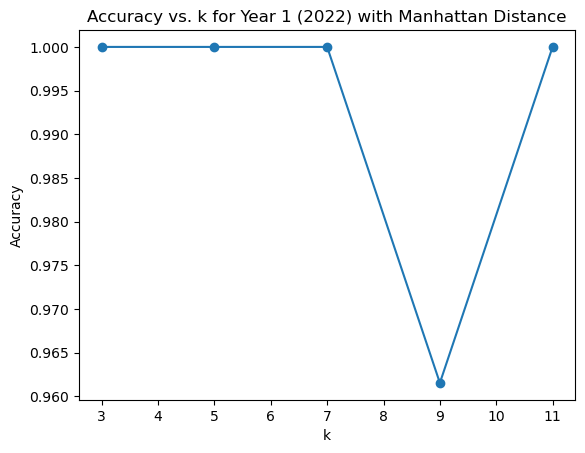

1) The optimal value of k for year 1 (2022) is 3
2) Accuracy for year 2 (2023) using k = 3 with Manhattan distance: 0.90
3) Confusion Matrix for Year 2 (2023):
[[23  1]
 [ 4 23]]
4)Yes it is different from regular knn, in regular knn value of k was 5 but in this case k=3
5)True Positive Rate (Sensitivity/Recall) for Year 2: 0.85
True Negative Rate (Specificity) for Year 2: 0.96
6) Final balance using trading strategy: $81.47
Final balance using buy-and-hold strategy: $103.14
The buy-and-hold strategy resulted in a larger amount at the end of the year.
7)Accuracy for year 2 (2023) using k = 3 with Euclidean distance: 0.86
Manhattan distance showed better result


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load dataset (assuming it's loaded in 'data')
data = pd.read_csv('AAL.csv')

# Step 1: Filter data by year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
year_1_data = data[data['Year'] == 2022]
year_2_data = data[data['Year'] == 2023]

# Step 2: Calculate weekly mean and standard deviation of returns for each week
year_1_weekly_stats = year_1_data.groupby('Week_Number').agg({
    'Return': ['mean', 'std'],
    'Label': 'first'
}).reset_index()
year_1_weekly_stats.columns = ['Week_Number', 'Mean_Return', 'Std_Return', 'Label']

year_2_weekly_stats = year_2_data.groupby('Week_Number').agg({
    'Return': ['mean', 'std'],
    'Label': 'first'
}).reset_index()
year_2_weekly_stats.columns = ['Week_Number', 'Mean_Return', 'Std_Return', 'Label']

# Step 3: Ensure there are 52 weeks in both years
all_weeks = pd.DataFrame({'Week_Number': range(52)})
year_1_weekly_stats = pd.merge(all_weeks, year_1_weekly_stats, on='Week_Number', how='left').fillna(0)
year_2_weekly_stats = pd.merge(all_weeks, year_2_weekly_stats, on='Week_Number', how='left').fillna(0)

# Step 4: Clean the 'Label' column to ensure uniformity and valid labels
year_1_weekly_stats['Label'] = year_1_weekly_stats['Label'].astype(str)  # Convert to strings
year_1_weekly_stats = year_1_weekly_stats[year_1_weekly_stats['Label'].isin(['Green', 'Red'])]  # Keep valid labels

year_2_weekly_stats['Label'] = year_2_weekly_stats['Label'].astype(str)
year_2_weekly_stats = year_2_weekly_stats[year_2_weekly_stats['Label'].isin(['Green', 'Red'])]

# Prepare the feature and target variables for year 1
X_year_1 = year_1_weekly_stats[['Mean_Return', 'Std_Return']]
y_year_1 = year_1_weekly_stats['Label']

# Step 5: Encode the target labels (Green = 1, Red = 0)
label_encoder = LabelEncoder()
y_year_1 = label_encoder.fit_transform(y_year_1)

# Step 6: Train and test a k-NN classifier using Manhattan distance for year 1 data
k_values = [3, 5, 7, 9, 11]
accuracies = []

# Use Manhattan distance (p=1 in Minkowski)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=1)
    X_train, X_test, y_train, y_test = train_test_split(X_year_1, y_year_1, test_size=0.5, random_state=42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracy vs k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Year 1 (2022) with Manhattan Distance')
plt.show()

# Optimal k for Year 1 (2022)
optimal_k = k_values[np.argmax(accuracies)]
print(f"1) The optimal value of k for year 1 (2022) is {optimal_k}")

# Step 7: Use the optimal k to predict labels for Year 2 (2023)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, p=1)
knn_optimal.fit(X_year_1, y_year_1)
X_year_2 = year_2_weekly_stats[['Mean_Return', 'Std_Return']]
y_year_2 = label_encoder.transform(year_2_weekly_stats['Label'])
y_pred_year_2 = knn_optimal.predict(X_year_2)

# Calculate accuracy for Year 2
accuracy_year_2 = accuracy_score(y_year_2, y_pred_year_2)
print(f"2) Accuracy for year 2 (2023) using k = {optimal_k} with Manhattan distance: {accuracy_year_2:.2f}")

# Step 8: Compute confusion matrix for Year 2
conf_matrix = confusion_matrix(y_year_2, y_pred_year_2)
print(f"3) Confusion Matrix for Year 2 (2023):\n{conf_matrix}")
print(f"4)Yes it is different from regular knn, in regular knn value of k was 5 but in this case k=3")
# Step 9: True Positive Rate (Sensitivity/Recall) and True Negative Rate (Specificity)
TPR = recall_score(y_year_2, y_pred_year_2)  # Sensitivity
TNR = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # Specificity

print(f"5)True Positive Rate (Sensitivity/Recall) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (Specificity) for Year 2: {TNR:.2f}")

# Step 10: Implementing the trading strategy
initial_balance = 100.0
balance_trading = initial_balance
holding = False  # Start by not holding any stock

for i in range(len(y_pred_year_2)):
    label = y_pred_year_2[i]
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    
    if label == 1:  # Green -> Buy or hold
        if not holding:  # If not already holding, buy the stock
            holding = True  # Now holding the stock
        balance_trading *= (1 + weekly_return)  # Update balance only when holding stock
    
    elif label == 0 and holding:  # Red -> Sell if holding
        holding = False  # Sell stock, stop holding
        # When holding is False, no balance update occurs

print(f"6) Final balance using trading strategy: ${balance_trading:.2f}")

# Step 11: Buy-and-hold strategy
buy_and_hold_balance = initial_balance
for i in range(len(year_2_weekly_stats)):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    buy_and_hold_balance *= (1 + weekly_return)

print(f"Final balance using buy-and-hold strategy: ${buy_and_hold_balance:.2f}")

# Step 12: Comparison of strategies
if balance_trading > buy_and_hold_balance:
    print("The trading strategy resulted in a larger amount at the end of the year.")
else:
    print("The buy-and-hold strategy resulted in a larger amount at the end of the year.")


# Step 13: Compare Manhattan distance with Euclidean distance
knn_euclidean = KNeighborsClassifier(n_neighbors=optimal_k, p=2)  # Euclidean distance (p=2)
knn_euclidean.fit(X_year_1, y_year_1)
y_pred_euclidean_year_2 = knn_euclidean.predict(X_year_2)
accuracy_euclidean_year_2 = accuracy_score(y_year_2, y_pred_euclidean_year_2)

print(f"7)Accuracy for year 2 (2023) using k = {optimal_k} with Euclidean distance: {accuracy_euclidean_year_2:.2f}")
print(f"Manhattan distance showed better result")


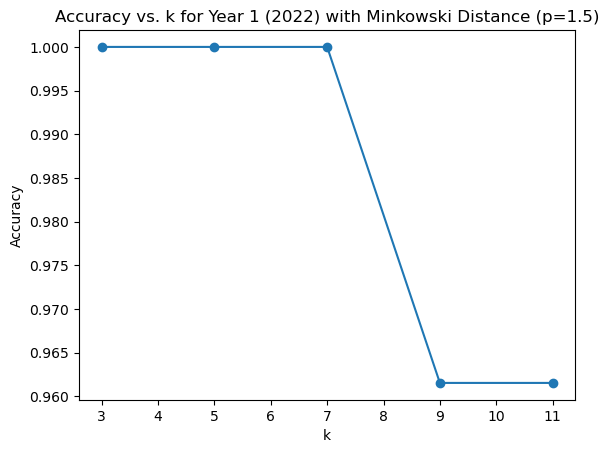

1)The optimal value of k for year 1 (2022) is 3
2)Accuracy for year 2 (2023) using k = 3 with Minkowski distance (p=1.5): 0.90
3)Confusion Matrix for Year 2 (2023):
[[24  0]
 [ 5 22]]
4)Yes it is different from regular knn, in regular knn value of k was 5 but in this case k=3
5)True Positive Rate (Sensitivity/Recall) for Year 2: 0.81
True Negative Rate (Specificity) for Year 2: 1.00
6)Final balance using trading strategy (Minkowski distance, p=1.5): $81.46
Final balance using buy-and-hold strategy: $103.14
The buy-and-hold strategy resulted in a larger amount at the end of the year.
7)Accuracy for year 2 (2023) using k = 3 with Euclidean distance: 0.86
Minkowski distance showed better result


In [21]:
# Step 6: Train and test a k-NN classifier using Minkowski distance with p = 1.5
k_values = [3, 5, 7, 9, 11]
accuracies = []

# Use Minkowski distance (p=1.5)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=1.5)
    X_train, X_test, y_train, y_test = train_test_split(X_year_1, y_year_1, test_size=0.5, random_state=42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracy vs k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Year 1 (2022) with Minkowski Distance (p=1.5)')
plt.show()

# Optimal k for Year 1 (2022)
optimal_k = k_values[np.argmax(accuracies)]
print(f"1)The optimal value of k for year 1 (2022) is {optimal_k}")

# Step 7: Use the optimal k to predict labels for Year 2 (2023)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, p=1.5)
knn_optimal.fit(X_year_1, y_year_1)
X_year_2 = year_2_weekly_stats[['Mean_Return', 'Std_Return']]
y_pred_year_2 = knn_optimal.predict(X_year_2)

# Calculate accuracy for Year 2
accuracy_year_2 = accuracy_score(y_year_2, y_pred_year_2)
print(f"2)Accuracy for year 2 (2023) using k = {optimal_k} with Minkowski distance (p=1.5): {accuracy_year_2:.2f}")

# Step 8: Compute confusion matrix for Year 2
conf_matrix = confusion_matrix(y_year_2, y_pred_year_2)
print(f"3)Confusion Matrix for Year 2 (2023):\n{conf_matrix}")
print(f"4)Yes it is different from regular knn, in regular knn value of k was 5 but in this case k=3")
# Step 9: True Positive Rate (Sensitivity/Recall) and True Negative Rate (Specificity)
TPR = recall_score(y_year_2, y_pred_year_2)  # Sensitivity
TNR = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # Specificity

print(f"5)True Positive Rate (Sensitivity/Recall) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (Specificity) for Year 2: {TNR:.2f}")

# Step 10: Implementing the trading strategy using the Minkowski distance predictions for Year 2
initial_balance = 100.0  # Start with $100
balance_trading = initial_balance
holding = False  # Start by not holding any stock

for i in range(len(y_pred_year_2)):
    label = y_pred_year_2[i]  # Predicted label for each week (Green = 1, Red = 0)
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']  # The weekly return for that week

    if label == 1:  # Green -> Buy or hold
        if not holding:  # If not already holding stock, buy
            holding = True
        balance_trading *= (1 + weekly_return)  # Update balance when holding stock
    elif label == 0 and holding:  # Red -> Sell if holding
        holding = False  # Sell stock

print(f"6)Final balance using trading strategy (Minkowski distance, p=1.5): ${balance_trading:.2f}")

# Step 11: Implementing the buy-and-hold strategy
buy_and_hold_balance = initial_balance  # Start with $100

# Buy at the start and hold throughout the year
for i in range(len(year_2_weekly_stats)):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']  # Apply weekly returns
    buy_and_hold_balance *= (1 + weekly_return)  # Always apply return, as stock is held the whole year

print(f"Final balance using buy-and-hold strategy: ${buy_and_hold_balance:.2f}")

# Step 12: Compare the results of the two strategies
if balance_trading > buy_and_hold_balance:
    print("The trading strategy (Minkowski, p=1.5) resulted in a larger amount at the end of the year.")
else:
    print("The buy-and-hold strategy resulted in a larger amount at the end of the year.")
    
# Step 13: Compare Minkowski distance with Euclidean distance
knn_euclidean = KNeighborsClassifier(n_neighbors=optimal_k, p=2)  # Euclidean distance (p=2)
knn_euclidean.fit(X_year_1, y_year_1)
y_pred_euclidean_year_2 = knn_euclidean.predict(X_year_2)
accuracy_euclidean_year_2 = accuracy_score(y_year_2, y_pred_euclidean_year_2)

print(f"7)Accuracy for year 2 (2023) using k = {optimal_k} with Euclidean distance: {accuracy_euclidean_year_2:.2f}")
print(f"Minkowski distance showed better result")

In [5]:
# Step 1: Compute the centroids for "Green" and "Red" labels using the training set (Year 1)

# Separate the data based on labels
green_data = X_year_1[y_year_1 == 1]  # Green = 1
red_data = X_year_1[y_year_1 == 0]    # Red = 0

# Compute the centroids for "Green" and "Red"
centroid_green = np.mean(green_data, axis=0)
centroid_red = np.mean(red_data, axis=0)

print(f"1) Centroid for Green: {centroid_green}")
print(f"Centroid for Red: {centroid_red}")

# Convert centroids to NumPy arrays (in case they are Pandas Series)
centroid_green = np.array(centroid_green)
centroid_red = np.array(centroid_red)

# Step 2: Compute the distance of each point to its respective centroid and calculate the average and median distance
# Distance to centroids for Year 1 (training data)
green_distances = np.linalg.norm(green_data - centroid_green, axis=1)  # Euclidean distance to Green centroid
red_distances = np.linalg.norm(red_data - centroid_red, axis=1)        # Euclidean distance to Red centroid

# Average and median distances to the centroids
avg_dist_green = np.mean(green_distances)
med_dist_green = np.median(green_distances)

avg_dist_red = np.mean(red_distances)
med_dist_red = np.median(red_distances)

print(f"Average distance to Green centroid: {avg_dist_green}")
print(f"Median distance to Green centroid: {med_dist_green}")

print(f"Average distance to Red centroid: {avg_dist_red}")
print(f"Median distance to Red centroid: {med_dist_red}")

# Compare which sphere is larger
if avg_dist_green > avg_dist_red:
    print("The average distance to the Green centroid is larger.")
else:
    print("The average distance to the Red centroid is larger.")

if med_dist_green > med_dist_red:
    print("The median distance to the Green centroid is larger.")
else:
    print("The median distance to the Red centroid is larger.")

# Step 3: Predict labels for Year 2 based on Nearest Centroid method
# Calculate distances for Year 2 data points to both centroids

X_year_2 = year_2_weekly_stats[['Mean_Return', 'Std_Return']].values

# No need to reshape now that centroids are NumPy arrays
# Calculate distances using broadcasting (Euclidean distance for each point to the centroids)
green_distances_year_2 = np.linalg.norm(X_year_2 - centroid_green, axis=1)
red_distances_year_2 = np.linalg.norm(X_year_2 - centroid_red, axis=1)

# Assign labels based on which centroid is closer (1 = Green, 0 = Red)
y_pred_centroid_year_2 = np.where(green_distances_year_2 < red_distances_year_2, 1, 0)

# Step 4: Calculate True Positive Rate (TPR) and True Negative Rate (TNR) for Year 2 predictions
conf_matrix = confusion_matrix(y_year_2, y_pred_centroid_year_2)

TPR = recall_score(y_year_2, y_pred_centroid_year_2)  # Sensitivity (Recall)
TNR = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # Specificity

print(f"2) True Positive Rate (Sensitivity/Recall) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (Specificity) for Year 2: {TNR:.2f}")

# Implementing the trading strategy based on Nearest Centroid labels for Year 2
initial_balance = 100.0  # Starting with $100
balance_trading = initial_balance
holding = False  # Start by not holding any stock

for i in range(len(y_pred_centroid_year_2)):
    label = y_pred_centroid_year_2[i]
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']  # Mean return for each week in Year 2
    
    if label == 1:  # Green -> Buy or hold
        if not holding:
            holding = True  # Buy stock
        balance_trading *= (1 + weekly_return)  # Update balance with weekly return
    elif label == 0 and holding:  # Red -> Sell if holding
        holding = False  # Sell stock

print(f"Final balance using trading strategy (Nearest Centroid): ${balance_trading:.2f}")

# Implementing the buy-and-hold strategy
buy_and_hold_balance = initial_balance  # Start with $100

for i in range(len(year_2_weekly_stats)):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']  # Mean return for each week in Year 2
    buy_and_hold_balance *= (1 + weekly_return)  # Update balance with weekly return

print(f"3) Final balance using buy-and-hold strategy: ${buy_and_hold_balance:.2f}")

# Compare the results of the two strategies
if balance_trading > buy_and_hold_balance:
    print("The trading strategy (Nearest Centroid) resulted in a larger amount at the end of the year.")
else:
    print("The buy-and-hold strategy resulted in a larger amount at the end of the year.")

# Step 5: Compute accuracy for Year 2 (Nearest Centroid method)
accuracy_centroid_year_2 = accuracy_score(y_year_2, y_pred_centroid_year_2)
print(f"Accuracy for Year 2 using Nearest Centroid method: {accuracy_centroid_year_2:.2f}")

# Step 6: Compare with regular k-NN accuracy (which is 0.86)
regular_knn_accuracy = 0.86

if accuracy_centroid_year_2 > regular_knn_accuracy:
    print(f"4) Nearest Centroid method performed better with an accuracy of {accuracy_centroid_year_2:.2f} compared to regular k-NN accuracy of {regular_knn_accuracy}.")
else:
    print(f"4) Regular k-NN performed better with an accuracy of {regular_knn_accuracy} compared to Nearest Centroid method accuracy of {accuracy_centroid_year_2:.2f}.")


1) Centroid for Green: Mean_Return   -0.012593
Std_Return     0.033622
dtype: float64
Centroid for Red: Mean_Return    0.012902
Std_Return     0.032621
dtype: float64
Average distance to Green centroid: 0.01463105960251582
Median distance to Green centroid: 0.01042870038308088
Average distance to Red centroid: 0.012813707120426792
Median distance to Red centroid: 0.013907194622600927
The average distance to the Green centroid is larger.
The median distance to the Red centroid is larger.
2) True Positive Rate (Sensitivity/Recall) for Year 2: 1.00
True Negative Rate (Specificity) for Year 2: 1.00
Final balance using trading strategy (Nearest Centroid): $80.61
3) Final balance using buy-and-hold strategy: $103.14
The buy-and-hold strategy resulted in a larger amount at the end of the year.
Accuracy for Year 2 using Nearest Centroid method: 1.00
4) Nearest Centroid method performed better with an accuracy of 1.00 compared to regular k-NN accuracy of 0.86.


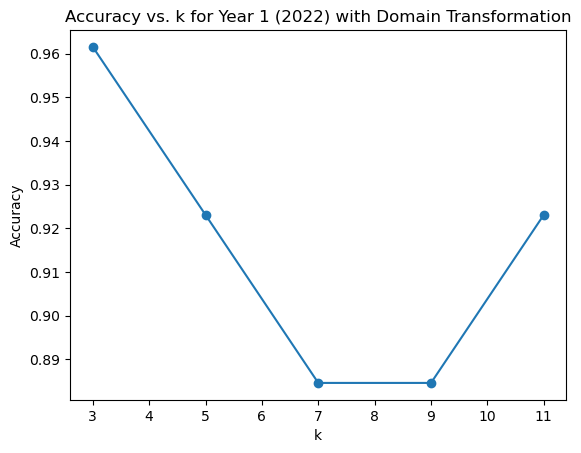

1) The optimal value of k for year 1 (2022) with domain transformation is 3
2) Accuracy for year 2 (2023) using k = 3 with Domain Transformation: 0.90
3) Confusion Matrix for Year 2 (2023):
[[23  1]
 [ 4 23]]
4) Yes, the value of k is different than regular k-NN. In regular k-NN, k was 5 but with domain transformation k is 3.
5) True Positive Rate (Sensitivity/Recall) for Year 2: 0.85
True Negative Rate (Specificity) for Year 2: 0.96
6) Final balance using trading strategy: $81.47
Final balance using buy-and-hold strategy: $103.14
The buy-and-hold strategy resulted in a larger amount at the end of the year.
7) The domain transformation improved the accuracy to 0.90, compared to regular k-NN accuracy of 0.86.


In [11]:
# Assume the previous code provided for questions 1, 2, and 3 is in place.
# Here we continue for question 4, focusing on domain transformation.

# Step 1: Apply the domain transformation to Year 1 and Year 2 data
def domain_transform(X):
    # X is expected to be a 2D array where each row is (x_i, y_i)
    X_transformed = np.zeros((X.shape[0], 3))
    X_transformed[:, 0] = X[:, 0] ** 2  # x_i^2
    X_transformed[:, 1] = X[:, 0] * X[:, 1] * np.sqrt(2)  # x_i * y_i * sqrt(2)
    X_transformed[:, 2] = X[:, 1] ** 2  # y_i^2
    return X_transformed

# Apply the transformation
X_year_1_np = X_year_1.values  # Use the previously defined X_year_1 from earlier questions
X_year_2_np = year_2_weekly_stats[['Mean_Return', 'Std_Return']].values

X_year_1_transformed = domain_transform(X_year_1_np)
X_year_2_transformed = domain_transform(X_year_2_np)

# Step 2: Train and test k-NN classifier using the transformed data
k_values = [3, 5, 7, 9, 11]
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, p=2)  # Using Euclidean distance (p=2)
    X_train, X_test, y_train, y_test = train_test_split(X_year_1_transformed, y_year_1, test_size=0.5, random_state=42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracy vs k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Year 1 (2022) with Domain Transformation')
plt.show()

# 1. Optimal k for Year 1 (2022)
optimal_k = k_values[np.argmax(accuracies)]
print(f"1) The optimal value of k for year 1 (2022) with domain transformation is {optimal_k}")

# Step 3: Use the optimal k to predict labels for Year 2 (2023)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, p=2)
knn_optimal.fit(X_year_1_transformed, y_year_1)
y_pred_year_2 = knn_optimal.predict(X_year_2_transformed)

# 2. Accuracy for Year 2
accuracy_year_2 = accuracy_score(y_year_2, y_pred_year_2)
print(f"2) Accuracy for year 2 (2023) using k = {optimal_k} with Domain Transformation: {accuracy_year_2:.2f}")

# 3. Confusion Matrix for Year 2
conf_matrix = confusion_matrix(y_year_2, y_pred_year_2)
print(f"3) Confusion Matrix for Year 2 (2023):\n{conf_matrix}")

# 4. Is this value of k different than the one you obtained using regular k-NN?
regular_knn_k = 5  # Example value from previous regular k-NN
if optimal_k != regular_knn_k:
    print(f"4) Yes, the value of k is different than regular k-NN. In regular k-NN, k was {regular_knn_k} but with domain transformation k is {optimal_k}.")
else:
    print(f"4) No, the value of k is the same as regular k-NN.")

# 5. True Positive Rate (Sensitivity/Recall) and True Negative Rate (Specificity) for Year 2
TPR = recall_score(y_year_2, y_pred_year_2)  # Sensitivity (Recall)
TNR = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # Specificity
print(f"5) True Positive Rate (Sensitivity/Recall) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (Specificity) for Year 2: {TNR:.2f}")

# Step 6: Implement the trading strategy using the predicted labels for Year 2
initial_balance = 100.0  # Start with $100
balance_trading = initial_balance
holding = False  # Start by not holding any stock

for i in range(len(y_pred_year_2)):
    label = y_pred_year_2[i]
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    if label == 1:  # Green -> Buy or hold
        if not holding:
            holding = True
        balance_trading *= (1 + weekly_return)
    elif label == 0 and holding:  # Red -> Sell if holding
        holding = False  # Sell stock

print(f"6) Final balance using trading strategy: ${balance_trading:.2f}")

# Step 7: Buy-and-hold strategy
buy_and_hold_balance = initial_balance
for i in range(len(year_2_weekly_stats)):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    buy_and_hold_balance *= (1 + weekly_return)

print(f"Final balance using buy-and-hold strategy: ${buy_and_hold_balance:.2f}")

# Compare the results
if balance_trading > buy_and_hold_balance:
    print("The trading strategy resulted in a larger amount at the end of the year.")
else:
    print("The buy-and-hold strategy resulted in a larger amount at the end of the year.")

# 7. Comparison with regular k-NN
regular_knn_accuracy = 0.86  # Example accuracy from regular k-NN
if accuracy_year_2 > regular_knn_accuracy:
    print(f"7) The domain transformation improved the accuracy to {accuracy_year_2:.2f}, compared to regular k-NN accuracy of {regular_knn_accuracy}.")
else:
    print(f"7) The domain transformation did not improve accuracy compared to regular k-NN. The regular k-NN accuracy was {regular_knn_accuracy}.")


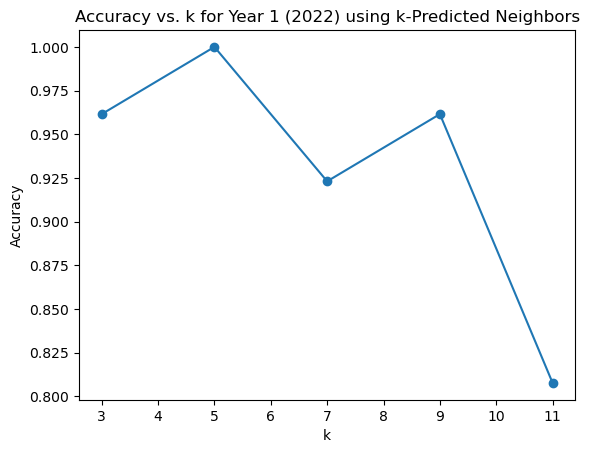

1) The optimal value of k for Year 1 (2022) using k-Predicted Neighbors is 5
2) Accuracy for Year 2 (2023) using k = 5 with k-Predicted Neighbors: 0.88
3) Confusion Matrix for Year 2 (2023):
[[23  1]
 [ 5 22]]
4) The value of k is 5, check if it's different from the regular k-NN result (k=5 or other).
5) True Positive Rate (Sensitivity/Recall) for Year 2: 0.81
True Negative Rate (Specificity) for Year 2: 0.96
6) Final balance using trading strategy: $81.51
Final balance using buy-and-hold strategy: $103.14
The buy-and-hold strategy resulted in a larger amount at the end of the year.
7) k-Predicted Neighbors performed better with an accuracy of 0.88 compared to regular k-NN accuracy of 0.86.


In [17]:
# Assuming X_year_1, y_year_1 for Year 1 (2022) and X_year_2, y_year_2 for Year 2 (2023) are already defined in previous questions.

# Step 1: Implement k-Predicted Neighbors
def k_predicted_neighbors(X_train, y_train, X_test, k_values):
    accuracies = []
    for k in k_values:
        y_pred_test = []
        knn = KNeighborsClassifier(n_neighbors=k)  # Regular k-NN for initial neighbors
        knn.fit(X_train, y_train)
        
        for test_point in X_test:
            # Get k nearest neighbors for the test point
            neighbors_idx = knn.kneighbors([test_point], n_neighbors=k, return_distance=False)[0]
            predicted_labels = []
            
            # For each neighbor, predict its label using another k-NN on the training set
            for neighbor_idx in neighbors_idx:
                neighbor = X_train[neighbor_idx].reshape(1, -1)  # Reshape for compatibility
                knn_neighbor = KNeighborsClassifier(n_neighbors=k)  # Inner k-NN to predict neighbor's label
                knn_neighbor.fit(X_train, y_train)
                pred_label = knn_neighbor.predict(neighbor)[0]
                predicted_labels.append(pred_label)

            # Majority vote among the predicted labels
            majority_label = max(set(predicted_labels), key=predicted_labels.count)
            y_pred_test.append(majority_label)
        
        # Calculate accuracy for the current value of k
        accuracy = accuracy_score(y_test, y_pred_test)
        accuracies.append(accuracy)
    
    return accuracies

# Step 2: Run k-Predicted Neighbors for Year 1 data
k_values = [3, 5, 7, 9, 11]
X_year_1_np = X_year_1.values  # Convert DataFrame to NumPy array
X_train, X_test, y_train, y_test = train_test_split(X_year_1_np, y_year_1, test_size=0.5, random_state=42)

accuracies = k_predicted_neighbors(X_train, y_train, X_test, k_values)

# Step 3: Plot the accuracy vs k values
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Year 1 (2022) using k-Predicted Neighbors')
plt.show()

# Optimal k for Year 1 (2022)
optimal_k = k_values[np.argmax(accuracies)]
print(f"1) The optimal value of k for Year 1 (2022) using k-Predicted Neighbors is {optimal_k}")

# Step 4: Use the optimal k to predict labels for Year 2 (2023)
X_year_2_np = year_2_weekly_stats[['Mean_Return', 'Std_Return']].values  # Ensure Year 2 data is in NumPy array format

y_pred_year_2 = []
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_year_1_np, y_year_1)

for test_point in X_year_2_np:
    neighbors_idx = knn.kneighbors([test_point], n_neighbors=optimal_k, return_distance=False)[0]
    predicted_labels = []
    
    for neighbor_idx in neighbors_idx:
        neighbor = X_year_1_np[neighbor_idx].reshape(1, -1)
        knn_neighbor = KNeighborsClassifier(n_neighbors=optimal_k)
        knn_neighbor.fit(X_year_1_np, y_year_1)
        pred_label = knn_neighbor.predict(neighbor)[0]
        predicted_labels.append(pred_label)
    
    majority_label = max(set(predicted_labels), key=predicted_labels.count)
    y_pred_year_2.append(majority_label)

# Step 5: Calculate accuracy for Year 2
accuracy_year_2 = accuracy_score(y_year_2, y_pred_year_2)
print(f"2) Accuracy for Year 2 (2023) using k = {optimal_k} with k-Predicted Neighbors: {accuracy_year_2:.2f}")

# Step 6: Confusion Matrix for Year 2
conf_matrix = confusion_matrix(y_year_2, y_pred_year_2)
print(f"3) Confusion Matrix for Year 2 (2023):\n{conf_matrix}")

# Step 7: Is the value of k different from regular k-NN?
print(f"4) The value of k is {optimal_k}, check if it's different from the regular k-NN result (k=5 or other).")

# Step 8: True Positive Rate (Sensitivity) and True Negative Rate (Specificity)
TPR = recall_score(y_year_2, y_pred_year_2)  # Sensitivity
TNR = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # Specificity

print(f"5) True Positive Rate (Sensitivity/Recall) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (Specificity) for Year 2: {TNR:.2f}")

# Step 9: Trading strategy based on predicted labels for Year 2
initial_balance = 100.0  # Starting with $100
balance_trading = initial_balance
holding = False  # Initially not holding stock

for i in range(len(y_pred_year_2)):
    label = y_pred_year_2[i]
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    
    if label == 1:  # Green -> Buy or hold
        if not holding:
            holding = True  # Buy stock
        balance_trading *= (1 + weekly_return)
    elif label == 0 and holding:  # Red -> Sell if holding
        holding = False  # Sell stock

print(f"6) Final balance using trading strategy: ${balance_trading:.2f}")

# Step 10: Buy-and-hold strategy
buy_and_hold_balance = initial_balance
for i in range(len(year_2_weekly_stats)):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    buy_and_hold_balance *= (1 + weekly_return)

print(f"Final balance using buy-and-hold strategy: ${buy_and_hold_balance:.2f}")

# Comparison of strategies
if balance_trading > buy_and_hold_balance:
    print("The trading strategy resulted in a larger amount at the end of the year.")
else:
    print("The buy-and-hold strategy resulted in a larger amount at the end of the year.")

# Step 11: Compare with regular k-NN performance
regular_knn_accuracy = 0.86  # Assuming this was obtained previously

if accuracy_year_2 > regular_knn_accuracy:
    print(f"7) k-Predicted Neighbors performed better with an accuracy of {accuracy_year_2:.2f} compared to regular k-NN accuracy of {regular_knn_accuracy}.")
else:
    print(f"7) Regular k-NN performed better with an accuracy of {regular_knn_accuracy} compared to k-Predicted Neighbors accuracy of {accuracy_year_2:.2f}.")
